<a href="https://colab.research.google.com/github/bahereh/Data-Science-Projects/blob/master/KPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

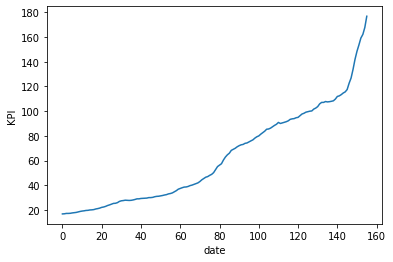

62 19


In [207]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# fix random seed for reproducibility
tf.random.set_seed(7)
dataframe = pd.read_csv('KPI.csv', usecols=[1], engine='python')
dataframe2 = pd.read_csv('KPI.csv', usecols=[0], engine='python')
names = dataframe2.values.astype('str')



dataset = dataframe.values
dataset = dataset.astype('float32')
plt.plot(dataset)
plt.xlabel('date')
plt.ylabel('KPI')
plt.show()

dataset = dataset[75:]
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) #
dataset = scaler.fit_transform(dataset) #.reshape(-1,1)
# dataset is between 0,1

# split into train and test sets
train_size = int(len(dataset) * 0.77)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


# convert an array of values into a dataset matrix
import numpy as np
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)


# reshape into X=t and Y=t+1
look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))


In [181]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(30,return_sequences=True,input_shape=(look_back,1)))
model.add(LSTM(30,return_sequences=True))
model.add(LSTM(30))
model.add(Dense(1)) # Final output
model.compile(loss='mean_squared_error', optimizer='adam')

In [182]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_57 (LSTM)              (None, 10, 30)            3840      
                                                                 
 lstm_58 (LSTM)              (None, 10, 30)            7320      
                                                                 
 lstm_59 (LSTM)              (None, 30)                7320      
                                                                 
 dense_19 (Dense)            (None, 1)                 31        
                                                                 
Total params: 18,511
Trainable params: 18,511
Non-trainable params: 0
_________________________________________________________________


In [183]:
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
51/51 - 5s - loss: 0.0178 - 5s/epoch - 89ms/step
Epoch 2/100
51/51 - 0s - loss: 0.0015 - 447ms/epoch - 9ms/step
Epoch 3/100
51/51 - 0s - loss: 5.3688e-04 - 444ms/epoch - 9ms/step
Epoch 4/100
51/51 - 0s - loss: 2.3984e-04 - 447ms/epoch - 9ms/step
Epoch 5/100
51/51 - 0s - loss: 1.4209e-04 - 434ms/epoch - 9ms/step
Epoch 6/100
51/51 - 0s - loss: 1.9808e-04 - 434ms/epoch - 9ms/step
Epoch 7/100
51/51 - 0s - loss: 1.5717e-04 - 441ms/epoch - 9ms/step
Epoch 8/100
51/51 - 0s - loss: 2.2231e-04 - 427ms/epoch - 8ms/step
Epoch 9/100
51/51 - 0s - loss: 4.0975e-04 - 433ms/epoch - 8ms/step
Epoch 10/100
51/51 - 0s - loss: 1.7677e-04 - 427ms/epoch - 8ms/step
Epoch 11/100
51/51 - 0s - loss: 2.4877e-04 - 448ms/epoch - 9ms/step
Epoch 12/100
51/51 - 0s - loss: 3.2298e-04 - 427ms/epoch - 8ms/step
Epoch 13/100
51/51 - 0s - loss: 1.3687e-04 - 435ms/epoch - 9ms/step
Epoch 14/100
51/51 - 0s - loss: 1.6464e-04 - 453ms/epoch - 9ms/step
Epoch 15/100
51/51 - 0s - loss: 2.3322e-04 - 450ms/epoch - 9ms/step

In [184]:


# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.58 RMSE
Test Score: 17.73 RMSE


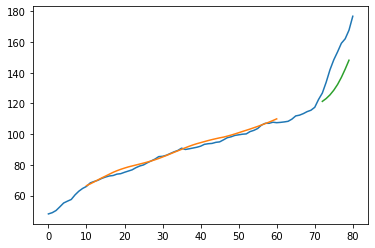

In [185]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()
# [USING THE TRAINED MODEL]

In [186]:
#Predict the future 12 month

x_input=test[len(test)-look_back:].reshape(1,-1)
x_input.shape
temp_input = list(x_input)
temp_input = temp_input[0].tolist() # take all the values
print(temp_input)
x_input.shape


[0.5788655281066895, 0.611499547958374, 0.6658896207809448, 0.728826642036438, 0.7793316841125488, 0.8197357654571533, 0.8632477521896362, 0.8857808113098145, 0.9292927980422974, 0.9999998807907104]


(1, 10)

In [187]:
# demonstrate prediction for next 10 days
from numpy import array
duration = 12
print(len(temp_input), temp_input, type(temp_input))
xxx = len(temp_input)
lst_output=[]
n_steps=look_back
i=0
while(i<duration): # FORECASTING #) DAYS
    
    if(xxx>look_back):
      #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
        xxx = len(list(temp_input))
    else:
      print('FIRST')
      x_input = x_input.reshape((1, n_steps,1))
      print(x_input)
      yhat = model.predict(x_input, verbose=0)
      print(yhat[0])
      temp_input.extend(yhat[0].tolist())
      print(len(temp_input))
      lst_output.extend(yhat.tolist())
      xxx = len(list(temp_input))
      i=i+1
    

print(lst_output)

10 [0.5788655281066895, 0.611499547958374, 0.6658896207809448, 0.728826642036438, 0.7793316841125488, 0.8197357654571533, 0.8632477521896362, 0.8857808113098145, 0.9292927980422974, 0.9999998807907104] <class 'list'>
FIRST
[[[0.5788655 ]
  [0.61149955]
  [0.6658896 ]
  [0.72882664]
  [0.7793317 ]
  [0.81973577]
  [0.86324775]
  [0.8857808 ]
  [0.9292928 ]
  [0.9999999 ]]]
[0.87439305]
11
1 day input [0.61149955 0.66588962 0.72882664 0.77933168 0.81973577 0.86324775
 0.88578081 0.9292928  0.99999988 0.87439305]
1 day output [[0.91665775]]
2 day input [0.66588962 0.72882664 0.77933168 0.81973577 0.86324775 0.88578081
 0.9292928  0.99999988 0.87439305 0.91665775]
2 day output [[0.95297164]]
3 day input [0.72882664 0.77933168 0.81973577 0.86324775 0.88578081 0.9292928
 0.99999988 0.87439305 0.91665775 0.95297164]
3 day output [[0.98220146]]
4 day input [0.77933168 0.81973577 0.86324775 0.88578081 0.9292928  0.99999988
 0.87439305 0.91665775 0.95297164 0.98220146]
4 day output [[1.0048977]]

In [188]:
print('THE PREDICTED DOLLAR VALUE IS: ', scaler.inverse_transform(lst_output))
print(len(lst_output))
tmp=test[len(test)-look_back:].reshape(1,-1)
tmp.shape
temp = list(tmp)
temp = temp[0].tolist() # take all the values
print(temp[-3:])
print(lst_output)
day_new=np.arange(1,51)
day_pred=np.arange(51,51+duration)
#https://github.com/krishnaik06/Stock-MArket-Forecasting/blob/master/Untitled.ipynb


THE PREDICTED DOLLAR VALUE IS:  [[160.63439575]
 [166.07386316]
 [170.74746144]
 [174.50933962]
 [177.43034813]
 [179.78140788]
 [181.74911115]
 [183.36009207]
 [184.85609827]
 [186.06630927]
 [186.82489084]
 [188.83394144]]
12
[0.8857808113098145, 0.9292927980422974, 0.9999998807907104]
[[0.8743930459022522], [0.9166577458381653], [0.9529716372489929], [0.9822014570236206], [1.0048977136611938], [1.0231654644012451], [1.038454532623291], [1.0509718656539917], [1.0625958442687988], [1.071999192237854], [1.0778933763504028], [1.093503713607788]]


81


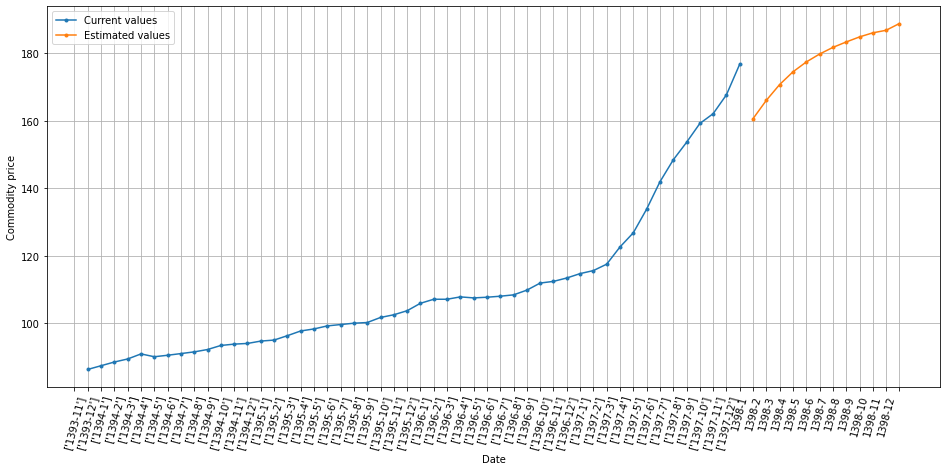

In [213]:
import matplotlib.pyplot as plt
print(len(dataset))

plt.figure(figsize=(16, 7))
plt.xlabel('Date')
plt.ylabel('Commodity price')
plt.plot(day_new,scaler.inverse_transform(dataset[len(dataset)-50:]),marker = '.')
plt.plot(day_pred,scaler.inverse_transform(lst_output),marker = '.')
new_names = ['1398-1','1398-2','1398-3','1398-4','1398-5','1398-6','1398-7','1398-8','1398-9','1398-10','1398-11','1398-12']
plt.legend(['Current values','Estimated values'])
plt.xticks([i for i in range(63)],list(names[-50:])+new_names,rotation = 75)
plt.grid()
